In [1]:
from topk_sae import FastAutoencoder
import numpy as np
import torch
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
path_16 = 'checkpoints/16_3072_24_auxk_epoch_50.pth'
path_32 = 'checkpoints/32_6144_48_auxk_epoch_50.pth'
path_64 = 'checkpoints/64_9216_128_auxk_epoch_50.pth'

In [3]:
# Configs for loading the FastAutoencoders
# Set grad to false
torch.set_grad_enabled(False)

model_configs = {
    '16': {
        'path': path_16,
        'd_model': 1536,
        'n_dirs': 3072,
        'k': 16,
        'auxk': 24
    },
    '32': {
        'path': path_32,
        'd_model': 1536,
        'n_dirs': 6144,
        'k': 32,
        'auxk': 48
    },
    '64': {
        'path': path_64,
        'd_model': 1536,
        'n_dirs': 1536 * 6,
        'k': 64,
        'auxk': 128
    }
}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
models = {}
for key, config in model_configs.items():
    model = FastAutoencoder(config['n_dirs'], config['d_model'], config['k'], config['auxk'], multik=0)
    model.load_state_dict(torch.load(config['path'], map_location=device))
    model = model.to(device)
    model.eval()
    models[key] = model

In [4]:
models

{'16': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=3072, bias=False)
   (decoder): Linear(in_features=3072, out_features=1536, bias=False)
 ),
 '32': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=6144, bias=False)
   (decoder): Linear(in_features=6144, out_features=1536, bias=False)
 ),
 '64': FastAutoencoder(
   (encoder): Linear(in_features=1536, out_features=9216, bias=False)
   (decoder): Linear(in_features=9216, out_features=1536, bias=False)
 )}

In [5]:
# Get the decoder matrices
decoders = {}
for key, model in models.items():
    decoders[key] = model.decoder.weight.data.cpu().numpy()

decoders['16'].shape, decoders['32'].shape, decoders['64'].shape

((1536, 3072), (1536, 6144), (1536, 9216))

In [39]:
import numpy as np
from scipy.linalg import qr, svd

def matrix_similarity_cca(A, B):
    # QR decomposition
    Q_A, _ = qr(A, mode='economic')
    Q_B, _ = qr(B, mode='economic')
    
    # SVD of Q_A^T Q_B
    U, S, _ = svd(Q_A.T @ Q_B)
    
    # Compute similarity
    k = min(A.shape[1], B.shape[1])
    similarity = np.mean(S[:k])
    
    return similarity

# Assuming decoders are already loaded as described
# decoders = {}
# for key, model in models.items():
#     decoders[key] = model.decoder.weight.data.cpu().numpy()

# Create a list of matrices in the order '16', '32', '64'
matrices = [decoders['16'], decoders['32'], decoders['64']]

# Verify shapes
print("Matrix shapes:")
for i, matrix in enumerate(matrices):
    print(f"Matrix {i+1}: {matrix.shape}")

# Compute pairwise similarities
n = len(matrices)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        sim = matrix_similarity_cca(matrices[i], matrices[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

print("\nPairwise Similarity Matrix:")
print(similarity_matrix)

# Optional: Create a more readable output
matrix_names = ['16', '32', '64']
print("\nPairwise Similarities:")
for i in range(n):
    for j in range(i+1, n):
        print(f"Similarity between decoder {matrix_names[i]} and decoder {matrix_names[j]}: {similarity_matrix[i, j]:.4f}")

Matrix shapes:
Matrix 1: (1536, 3072)
Matrix 2: (1536, 6144)
Matrix 3: (1536, 9216)

Pairwise Similarity Matrix:
[[1.         1.         1.        ]
 [1.         0.99999994 1.        ]
 [1.         1.         0.99999994]]

Pairwise Similarities:
Similarity between decoder 16 and decoder 32: 1.0000
Similarity between decoder 16 and decoder 64: 1.0000
Similarity between decoder 32 and decoder 64: 1.0000


In [37]:
import numpy as np
from scipy.linalg import qr, svd

def matrix_similarity_cca(A, B):
    # QR decomposition
    Q_A, _ = qr(A, mode='economic')
    Q_B, _ = qr(B, mode='economic')
    
    # SVD of Q_A^T Q_B
    U, S, _ = svd(Q_A.T @ Q_B)
    
    # Compute similarity
    k = min(A.shape[1], B.shape[1])
    similarity = np.mean(S[:k])
    
    return similarity

# Generate random matrices for demonstration
np.random.seed(42)
matrices = [
    np.random.randn(1536, 3072),
    np.random.randn(1536, 6144),
    np.random.randn(1536, 9216)
]

# Compute pairwise similarities
n = len(matrices)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        sim = matrix_similarity_cca(matrices[i], matrices[j])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

print("Pairwise Similarity Matrix:")
print(similarity_matrix)

Pairwise Similarity Matrix:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [38]:
import numpy as np
from scipy.linalg import qr, svd

def matrix_similarity_cca(A, B, debug=False):
    # QR decomposition
    Q_A, _ = qr(A, mode='economic')
    Q_B, _ = qr(B, mode='economic')
    
    if debug:
        print(f"Q_A shape: {Q_A.shape}, Q_B shape: {Q_B.shape}")
        print(f"Q_A frobenius norm: {np.linalg.norm(Q_A)}")
        print(f"Q_B frobenius norm: {np.linalg.norm(Q_B)}")
    
    # SVD of Q_A^T Q_B
    U, S, _ = svd(Q_A.T @ Q_B)
    
    if debug:
        print(f"Top 5 singular values: {S[:5]}")
    
    # Compute similarity
    k = min(A.shape[1], B.shape[1])
    similarity = np.mean(S[:k])
    
    return similarity

def cosine_similarity(A, B):
    # Compute column-wise means
    A_mean = np.mean(A, axis=0)
    B_mean = np.mean(B, axis=0)
    
    # Compute cosine similarity
    dot_product = np.dot(A_mean, B_mean)
    norm_A = np.linalg.norm(A_mean)
    norm_B = np.linalg.norm(B_mean)
    
    return dot_product / (norm_A * norm_B)

# Assuming decoders are already loaded
matrices = [decoders['16'], decoders['32'], decoders['64']]

# Verify shapes
print("Matrix shapes:")
for i, matrix in enumerate(matrices):
    print(f"Matrix {i+1}: {matrix.shape}")

# Compute pairwise similarities
n = len(matrices)
cca_similarity_matrix = np.zeros((n, n))
cosine_similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        cca_sim = matrix_similarity_cca(matrices[i], matrices[j], debug=(i != j))
        cos_sim = cosine_similarity(matrices[i], matrices[j])
        cca_similarity_matrix[i, j] = cca_sim
        cca_similarity_matrix[j, i] = cca_sim
        cosine_similarity_matrix[i, j] = cos_sim
        cosine_similarity_matrix[j, i] = cos_sim

print("\nPairwise CCA Similarity Matrix:")
print(cca_similarity_matrix)

print("\nPairwise Cosine Similarity Matrix:")
print(cosine_similarity_matrix)

# More readable output
matrix_names = ['16', '32', '64']
print("\nPairwise Similarities:")
for i in range(n):
    for j in range(i+1, n):
        print(f"Similarity between decoder {matrix_names[i]} and decoder {matrix_names[j]}:")
        print(f"  CCA: {cca_similarity_matrix[i, j]:.6f}")
        print(f"  Cosine: {cosine_similarity_matrix[i, j]:.6f}")

Matrix shapes:
Matrix 1: (1536, 3072)
Matrix 2: (1536, 6144)
Matrix 3: (1536, 9216)
Q_A shape: (1536, 1536), Q_B shape: (1536, 1536)
Q_A frobenius norm: 39.19176483154297
Q_B frobenius norm: 39.19175338745117
Top 5 singular values: [1.000003  1.000003  1.000003  1.000003  1.0000027]


ValueError: shapes (3072,) and (6144,) not aligned: 3072 (dim 0) != 6144 (dim 0)

In [42]:
import numpy as np
from scipy.linalg import svd

def subspace_similarity(A, B, k=None):
    """
    Compute similarity between column spaces of A and B using truncated SVD.
    k: number of singular values to consider (default: min of column counts)
    """
    if k is None:
        k = min(A.shape[1], B.shape[1])
    
    # Compute SVD for both matrices
    _, s_A, _ = svd(A, full_matrices=False)
    _, s_B, _ = svd(B, full_matrices=False)
    
    # Truncate singular values
    s_A = s_A[:k]
    s_B = s_B[:k]
    
    # Normalize and compute similarity
    norm_A = np.linalg.norm(s_A)
    norm_B = np.linalg.norm(s_B)
    similarity = np.dot(s_A, s_B) / (norm_A * norm_B)
    
    return similarity

def mean_column_cosine_similarity(A, B):
    """
    Compute mean cosine similarity between columns of A and B.
    """
    # Normalize columns of A and B
    A_norm = A / np.linalg.norm(A, axis=0, keepdims=True)
    B_norm = B / np.linalg.norm(B, axis=0, keepdims=True)
    
    # Compute all pairwise cosine similarities
    similarities = np.dot(A_norm.T, B_norm)
    
    # Return mean similarity
    return np.mean(similarities)

# Assuming decoders are already loaded
matrices = [decoders['16'], decoders['32'], decoders['64']]
# matrices = [
#     np.random.randn(1536, 3072),
#     np.random.randn(1536, 6144),
#     np.random.randn(1536, 9216)
# ]

# Verify shapes
print("Matrix shapes:")
for i, matrix in enumerate(matrices):
    print(f"Matrix {i+1}: {matrix.shape}")

# Compute pairwise similarities
n = len(matrices)
subspace_similarity_matrix = np.zeros((n, n))
cosine_similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        subspace_sim = subspace_similarity(matrices[i], matrices[j])
        cosine_sim = mean_column_cosine_similarity(matrices[i], matrices[j])
        subspace_similarity_matrix[i, j] = subspace_sim
        subspace_similarity_matrix[j, i] = subspace_sim
        cosine_similarity_matrix[i, j] = cosine_sim
        cosine_similarity_matrix[j, i] = cosine_sim

print("\nPairwise Subspace Similarity Matrix:")
print(subspace_similarity_matrix)

print("\nPairwise Mean Column Cosine Similarity Matrix:")
print(cosine_similarity_matrix)

# More readable output
matrix_names = ['16', '32', '64']
print("\nPairwise Similarities:")
for i in range(n):
    for j in range(i+1, n):
        print(f"Similarity between decoder {matrix_names[i]} and decoder {matrix_names[j]}:")
        print(f"  Subspace: {subspace_similarity_matrix[i, j]:.6f}")
        print(f"  Mean Column Cosine: {cosine_similarity_matrix[i, j]:.6f}")

Matrix shapes:
Matrix 1: (1536, 3072)
Matrix 2: (1536, 6144)
Matrix 3: (1536, 9216)

Pairwise Subspace Similarity Matrix:
[[1.         0.99821895 0.99733949]
 [0.99821895 1.00000012 0.99965   ]
 [0.99733949 0.99965    0.99999988]]

Pairwise Mean Column Cosine Similarity Matrix:
[[0.02013989 0.01363753 0.00955944]
 [0.01363753 0.01015453 0.0070802 ]
 [0.00955944 0.0070802  0.00538376]]

Pairwise Similarities:
Similarity between decoder 16 and decoder 32:
  Subspace: 0.998219
  Mean Column Cosine: 0.013638
Similarity between decoder 16 and decoder 64:
  Subspace: 0.997339
  Mean Column Cosine: 0.009559
Similarity between decoder 32 and decoder 64:
  Subspace: 0.999650
  Mean Column Cosine: 0.007080


In [44]:
import numpy as np
from scipy.spatial.distance import cosine

def get_top_and_bottom_similar_columns(sae1, sae2, n=10):
    """
    Find the top n and bottom n most similar column vectors between two SAE decoders based on cosine similarity.
    
    :param sae1: Decoder matrix of the first SAE
    :param sae2: Decoder matrix of the second SAE
    :param n: Number of top and bottom similar pairs to return (default: 10)
    :return: Two lists of tuples containing (similarity, index1, index2) for top and bottom similarities
    """
    # Normalize the columns of both matrices
    sae1_norm = sae1 / np.linalg.norm(sae1, axis=0, keepdims=True)
    sae2_norm = sae2 / np.linalg.norm(sae2, axis=0, keepdims=True)
    
    # Compute cosine similarities between all pairs of columns
    similarity_matrix = np.dot(sae1_norm.T, sae2_norm)
    
    # Get the indices of the top n and bottom n similarities
    top_indices = np.unravel_index(np.argsort(similarity_matrix.ravel())[-n:], similarity_matrix.shape)
    bottom_indices = np.unravel_index(np.argsort(similarity_matrix.ravel())[:n], similarity_matrix.shape)
    
    # Create lists of (similarity, index1, index2) tuples for top and bottom similarities
    top_similarities = []
    bottom_similarities = []
    
    for i, j in zip(top_indices[0], top_indices[1]):
        similarity = similarity_matrix[i, j]
        top_similarities.append((similarity, i, j))
    
    for i, j in zip(bottom_indices[0], bottom_indices[1]):
        similarity = similarity_matrix[i, j]
        bottom_similarities.append((similarity, i, j))
    
    # Sort in descending order of similarity for top similarities
    top_similarities.sort(reverse=True)
    # Sort in ascending order of similarity for bottom similarities
    bottom_similarities.sort()
    
    return top_similarities, bottom_similarities

# Example usage
# Assuming decoders is a dictionary containing the decoder matrices
decoders = {
    '16': decoders['16'],
    '32': decoders['32'],
    '64': decoders['64']
}

def print_similarities(top_sim, bottom_sim, sae1_name, sae2_name):
    print(f"\nTop 10 similar columns between {sae1_name} and {sae2_name}:")
    for similarity, idx1, idx2 in top_sim:
        print(f"Similarity: {similarity:.4f}, {sae1_name} column: {idx1}, {sae2_name} column: {idx2}")
    
    print(f"\nBottom 10 similar columns between {sae1_name} and {sae2_name}:")
    for similarity, idx1, idx2 in bottom_sim:
        print(f"Similarity: {similarity:.4f}, {sae1_name} column: {idx1}, {sae2_name} column: {idx2}")

# Compare SAE16 and SAE32
top_16_32, bottom_16_32 = get_top_and_bottom_similar_columns(decoders['16'], decoders['32'])
print_similarities(top_16_32, bottom_16_32, 'SAE16', 'SAE32')

# Compare SAE32 and SAE64
top_32_64, bottom_32_64 = get_top_and_bottom_similar_columns(decoders['32'], decoders['64'])
print_similarities(top_32_64, bottom_32_64, 'SAE32', 'SAE64')

# Compare SAE16 and SAE64
top_16_64, bottom_16_64 = get_top_and_bottom_similar_columns(decoders['16'], decoders['64'])
print_similarities(top_16_64, bottom_16_64, 'SAE16', 'SAE64')


Top 10 similar columns between SAE16 and SAE32:
Similarity: 0.9960, SAE16 column: 2645, SAE32 column: 4236
Similarity: 0.9960, SAE16 column: 549, SAE32 column: 3945
Similarity: 0.9960, SAE16 column: 2537, SAE32 column: 3013
Similarity: 0.9955, SAE16 column: 2210, SAE32 column: 6100
Similarity: 0.9952, SAE16 column: 774, SAE32 column: 5204
Similarity: 0.9952, SAE16 column: 292, SAE32 column: 2239
Similarity: 0.9951, SAE16 column: 1569, SAE32 column: 3932
Similarity: 0.9951, SAE16 column: 1986, SAE32 column: 4749
Similarity: 0.9950, SAE16 column: 2958, SAE32 column: 4011
Similarity: 0.9948, SAE16 column: 2398, SAE32 column: 2531

Bottom 10 similar columns between SAE16 and SAE32:
Similarity: -0.7161, SAE16 column: 497, SAE32 column: 115
Similarity: -0.5957, SAE16 column: 1631, SAE32 column: 6031
Similarity: -0.5893, SAE16 column: 1534, SAE32 column: 17
Similarity: -0.5741, SAE16 column: 198, SAE32 column: 1694
Similarity: -0.5691, SAE16 column: 1086, SAE32 column: 1141
Similarity: -0.56

In [49]:
import numpy as np
import plotly.graph_objects as go
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import json

# Assuming decoders is a dictionary containing the decoder matrices
decoders = {
    '16': decoders['16'],
    '32': decoders['32'],
    '64': decoders['64']
}

def load_feature_labels(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return {item['index']: item['label'] for item in data}

def prepare_data(decoders):
    all_columns = []
    labels = []
    sizes = []
    hover_texts = []
    
    feature_labels = {
        '16': load_feature_labels('sae_data/feature_analysis_results_16.json'),
        '32': load_feature_labels('sae_data/feature_analysis_results_32.json'),
        '64': load_feature_labels('sae_data/feature_analysis_results_64.json')
    }
    
    for key, matrix in decoders.items():
        columns = matrix.T  # Transpose to get column vectors
        all_columns.append(columns)
        labels.extend([f'SAE{key}'] * columns.shape[0])
        sizes.extend([key] * columns.shape[0])
        hover_texts.extend([f"SAE{key} - Feature {i}: {feature_labels[key].get(i, 'N/A')}" 
                            for i in range(columns.shape[0])])
    
    all_columns = np.vstack(all_columns)
    return all_columns, labels, sizes, hover_texts

def plot_umap(embedding, labels, sizes, hover_texts, filename='decoder_umap.html'):
    colors = {'SAE16': '#1f77b4', 'SAE32': '#ff7f0e', 'SAE64': '#2ca02c'}
    
    fig = go.Figure()
    
    for sae in ['SAE16', 'SAE32', 'SAE64']:
        mask = np.array(labels) == sae
        fig.add_trace(go.Scattergl(
            x=embedding[mask, 0],
            y=embedding[mask, 1],
            mode='markers',
            name=sae,
            marker=dict(
                color=colors[sae],
                size=5,
                opacity=0.7
            ),
            text=[text for text, label in zip(hover_texts, labels) if label == sae],
            hoverinfo='text'
        ))
    
    fig.update_layout(
        title='UMAP Projection of Decoder Column Vectors',
        xaxis_title='UMAP1',
        yaxis_title='UMAP2',
        legend_title='Decoder Size',
        font=dict(size=12),
        hovermode='closest',
        width=1000,
        height=800
    )
    
    fig.show()

# Prepare the data
all_columns, labels, sizes, hover_texts = prepare_data(decoders)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(all_columns)

# Perform UMAP
umap_model = UMAP(n_neighbors=100, n_components=2, random_state=42)
embedding = umap_model.fit_transform(normalized_data)

# Plot the results
plot_umap(embedding, labels, sizes, hover_texts)

print("UMAP visualization has been saved as 'decoder_umap.html'")

/Users/charlesoneill/miniconda3/envs/saerch/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP visualization has been saved as 'decoder_umap.html'


In [16]:
# Get all the indices and values across abstracts and save
batch_size = 1024

# Load abstract embeddings
abstract_embeddings = np.load("../data/vector_store/abstract_embeddings.npy")
abstract_embeddings = abstract_embeddings.astype(np.float32)

# Create a DataLoader for efficient batching
dataset = TensorDataset(torch.from_numpy(abstract_embeddings))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for key, ae in models.items():
    k = int(key)

    # Prepare arrays to store results
    num_abstracts = len(abstract_embeddings)
    topk_indices = np.zeros((num_abstracts, k), dtype=np.int64)
    topk_values = np.zeros((num_abstracts, k), dtype=np.float32)

    # Process batches
    with torch.no_grad():
        for i, (batch,) in enumerate(tqdm(dataloader, desc="Processing abstracts")):
            batch = batch.to(device)
            _, info = ae(batch)
            
            start_idx = i * batch_size
            end_idx = start_idx + batch.size(0)
            
            topk_indices[start_idx:end_idx] = info['topk_indices'].cpu().numpy()
            topk_values[start_idx:end_idx] = info['topk_values'].cpu().numpy()

    # Save results
    np.save(f"sae_data/topk_indices_{k}.npy", topk_indices)
    np.save(f"sae_data/topk_values_{k}.npy", topk_values)

    print("Processing complete. Results saved in 'sae_data' folder.")

Processing abstracts: 100%|██████████| 266/266 [00:08<00:00, 31.54it/s]


Processing complete. Results saved in 'sae_data' folder.


Processing abstracts: 100%|██████████| 266/266 [00:15<00:00, 17.17it/s]


Processing complete. Results saved in 'sae_data' folder.


Processing abstracts: 100%|██████████| 266/266 [00:21<00:00, 12.24it/s]

Processing complete. Results saved in 'sae_data' folder.


## Loading top-k indices and values for each of the models

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import networkx as nx
import torch

In [3]:
index_value_dict = {}

for k in [16, 32, 64]:
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    print(f"Top-{k} indices shape: {indices.shape}")
    print(f"Top-{k} values shape: {values.shape}")
    index_value_dict[k] = (indices, values)
    print()

Top-16 indices shape: (271492, 16)
Top-16 values shape: (271492, 16)

Top-32 indices shape: (271492, 32)
Top-32 values shape: (271492, 32)

Top-64 indices shape: (271492, 64)
Top-64 values shape: (271492, 64)



In [22]:
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def load_data(k):
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    return indices, values

def get_total_features(k):
    feature_counts = {16: 3072, 32: 6144, 64: 9216}
    return feature_counts[k]

def create_activation_matrix(indices, values, k, n_papers):
    n_features = get_total_features(k)
    rows = np.repeat(np.arange(n_papers), k)
    cols = indices.flatten()
    data = values.flatten()
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_papers, n_features))

def compute_inter_sae_correlation(sae1_matrix, sae2_matrix, k1, k2):
    n_features1 = get_total_features(k1)
    n_features2 = get_total_features(k2)
    correlation_matrix = np.zeros((n_features1, n_features2))
    
    for i in tqdm(range(n_features1)):
        if i % 100 == 0:
            print(f"Processing feature {i} of SAE-{k1}")
        i_activations = sae1_matrix[:, i].toarray().flatten()
        for j in tqdm(range(n_features2)):
            j_activations = sae2_matrix[:, j].toarray().flatten()
            
            # Get non-zero entries for both features
            mask = (i_activations != 0) & (j_activations != 0)
            if np.sum(mask) > 1:  # Need at least 2 points for correlation
                corr, _ = spearmanr(i_activations[mask], j_activations[mask])
                correlation_matrix[i, j] = corr
    
    return correlation_matrix

def plot_heatmap(matrix, title, filename):
    plt.figure(figsize=(20, 16))
    sns.heatmap(matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(title)
    plt.xlabel("Features of wider SAE")
    plt.ylabel("Features of narrower SAE")
    plt.tight_layout()
    #plt.savefig(filename, dpi=300)
    #plt.close()
    plt.show()

# Load data and create activation matrices for all SAEs
sae_data = {}
for k in [16, 32, 64]:
    indices, values = load_data(k)
    n_papers = indices.shape[0]
    sae_data[k] = create_activation_matrix(indices, values, k, n_papers)

# Compute and visualize inter-SAE correlations
sae_pairs = [(16, 32), (16, 64), (32, 64)]

for k1, k2 in sae_pairs:
    print(f"Computing correlations between SAE-{k1} and SAE-{k2}")
    correlation_matrix = compute_inter_sae_correlation(sae_data[k1], sae_data[k2], k1, k2)
    
    # Save correlation matrix
    #np.save(f"sae_{k1}_{k2}_correlation.npy", correlation_matrix)
    
    # Plot heatmap
    plot_heatmap(correlation_matrix, f"Feature Correlations: SAE-{k1} vs SAE-{k2}", f"sae_{k1}_{k2}_correlation_heatmap.png")

print("Analysis complete. Correlation matrices and heatmaps have been saved.")

Computing correlations between SAE-16 and SAE-32


  0%|          | 0/3072 [00:00<?, ?it/s]

Processing feature 0 of SAE-16


  0%|          | 1/3072 [01:19<68:01:22, 79.74s/it]


KeyboardInterrupt: 

## Summary statistics over features

In [90]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

def calculate_log_feature_density(topk_indices, n_dirs):
    num_samples, k = topk_indices.shape
    feature_counts = np.bincount(topk_indices.flatten(), minlength=n_dirs)
    feature_density = feature_counts / num_samples
    log_feature_density = np.log10(feature_density + 1e-10)  # Use log10 for easier interpretation
    return log_feature_density

def calculate_histogram(x, start=-6, end=0, bin_size=0.1):
    bins = np.arange(start, end + bin_size, bin_size)
    counts, _ = np.histogram(x, bins=bins)
    return bins[:-1], counts

def plot_log_feature_density(index_value_dict, model_configs, save_path=None):
    # Calculate log feature densities
    log_fd_dict = {k: calculate_log_feature_density(indices, model_configs[k]['n_dirs']) 
                   for k, (indices, _) in index_value_dict.items()}

    # Create figure
    fig = go.Figure()

    # Color-blind friendly palette
    colors = ['#4e79a7', '#f28e2b', '#59a14f']
    
    # Add histograms, KDE, and mean markers in the desired order: 16, 32, 64
    for i, k in enumerate(['16', '32', '64']):
        log_fd = log_fd_dict[k]
        name = f'SAE{k}'
        
        # Calculate histogram
        bins, counts = calculate_histogram(log_fd)
        
        # Add histogram trace
        fig.add_trace(go.Bar(
            x=bins,
            y=counts,
            name=name,
            marker_color=colors[i],
            opacity=0.7,
            showlegend=True  # Show in legend
        ))

        # Add KDE
        kde = stats.gaussian_kde(log_fd)
        x_range = np.linspace(-6, 0, 200)
        y_kde = kde(x_range)
        fig.add_trace(go.Scatter(
            x=x_range,
            y=y_kde * counts.max() / y_kde.max(),  # Scale KDE to match histogram height
            mode='lines',
            line=dict(color=colors[i], width=4),
            showlegend=False  # Hide from legend
        ))

        # Add mean marker
        mean = np.mean(log_fd)
        fig.add_trace(go.Scatter(
            x=[mean],
            y=[0],
            mode='markers',
            marker=dict(symbol='diamond', size=18, color=colors[i], line=dict(width=2, color='white')),
            showlegend=False  # Hide from legend
        ))

    # Update layout
    fig.update_layout(
        xaxis_title={
            'text': 'Log Feature Density',
            'font': dict(size=30, family='Palatino')
        },
        yaxis_title={
            'text': 'Frequency',
            'font': dict(size=30, family='Palatino')
        },
        font=dict(family='Palatino'),
        legend=dict(
            title=dict(text='Model', font=dict(size=30)),
            font=dict(size=30)
        ),
        barmode='stack',  # Stacked histogram
        bargap=0.1,
        bargroupgap=0.2,
        plot_bgcolor='white',
        width=1000,
        height=600
    )

    # Update axes
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='gray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24),
        range=[-5, 0]  # Set x-axis range
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='gray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24)
    )

    if save_path:
        fig.write_image(save_path, scale=2)
        print(f"Figure saved to {save_path}")
    else:
        fig.show()

# Model configurations
model_configs = {
    '16': {
        'd_model': 1536,
        'n_dirs': 3072,
        'k': 16,
        'auxk': 24
    },
    '32': {
        'd_model': 1536,
        'n_dirs': 6144,
        'k': 32,
        'auxk': 48
    },
    '64': {
        'd_model': 1536,
        'n_dirs': 1536 * 6,
        'k': 64,
        'auxk': 128
    }
}

# Load the data
index_value_dict = {}
for k in ['16', '32', '64']:
    indices = np.load(f"sae_data/topk_indices_{k}.npy")
    values = np.load(f"sae_data/topk_values_{k}.npy")
    print(f"Top-{k} indices shape: {indices.shape}")
    print(f"Top-{k} values shape: {values.shape}")
    index_value_dict[k] = (indices, values)
    print()

# Generate the plot
plot_log_feature_density(index_value_dict, model_configs, "../results/log_feature_density.pdf")

Top-16 indices shape: (271492, 16)
Top-16 values shape: (271492, 16)

Top-32 indices shape: (271492, 32)
Top-32 values shape: (271492, 32)

Top-64 indices shape: (271492, 64)
Top-64 values shape: (271492, 64)

Figure saved to ../results/log_feature_density.pdf


## Autointerp distributions

In [105]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import json

def load_pearson_correlations(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return [result['pearson_correlation'] for result in data]

def calculate_histogram(x, start=-1, end=1, bin_size=0.05):
    bins = np.arange(start, end + bin_size, bin_size)
    counts, _ = np.histogram(x, bins=bins)
    return bins[:-1], counts

def plot_pearson_correlations(correlation_dict, save_path=None):
    # Create figure
    fig = go.Figure()

    # Color-blind friendly palette (consistent with previous plot)
    colors = ['#4e79a7', '#f28e2b', '#59a14f']
    
    # Ensure the order of SAE models: 16, 32, 64
    ordered_keys = ['16', '32', '64']
    
    # Add histograms and KDEs for each SAE model
    for i, k in enumerate(ordered_keys):
        correlations = correlation_dict[k]
        name = f'SAE{k}'
        
        # Remove NaN and infinite values
        valid_correlations = np.array([c for c in correlations if np.isfinite(c)])
        
        # Calculate histogram
        bins, counts = calculate_histogram(valid_correlations)
        
        # Add histogram trace
        fig.add_trace(go.Bar(
            x=bins,
            y=counts,
            name=name,
            marker_color=colors[i],
            opacity=0.8
        ))

        # Add KDE
        kde = stats.gaussian_kde(valid_correlations)
        x_range = np.linspace(-1, 1, 200)
        y_kde = kde(x_range)
        fig.add_trace(go.Scatter(
            x=x_range,
            y=y_kde * counts.max() / y_kde.max(),  # Scale KDE to match histogram height
            mode='lines',
            line=dict(color=colors[i], width=4),
            showlegend=False
        ))

        # Print statistics
        mean = np.mean(valid_correlations)
        median = np.median(valid_correlations)
        print(f"{name} statistics:")
        print(f"  Total correlations: {len(correlations)}")
        print(f"  Valid correlations: {len(valid_correlations)}")
        print(f"  Invalid correlations: {len(correlations) - len(valid_correlations)}")
        print(f"  Mean correlation: {mean:.4f}")
        print(f"  Median correlation: {median:.4f}")
        print()

        # Add mean marker
        fig.add_trace(go.Scatter(
            x=[median],
            y=[0],
            mode='markers',
            marker=dict(symbol='diamond', size=24, color=colors[i], line=dict(width=3, color='white')),
            showlegend=False
        ))

    # Update layout
    fig.update_layout(
        xaxis_title={
            'text': 'Pearson Correlation',
            'font': dict(size=30, family='Palatino')
        },
        yaxis_title={
            'text': 'Frequency',
            'font': dict(size=30, family='Palatino')
        },
        font=dict(family='Palatino'),
        legend=dict(
            title=dict(text='Model', font=dict(size=24)),
            font=dict(size=24)
        ),
        barmode='stack',  # Stack the histograms
        bargap=0.1,
        bargroupgap=0.2,
        plot_bgcolor='white',
        width=1000,
        height=600
    )

    # Update axes
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24),
        range=[-1, 1]  # Set x-axis range
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24)
    )

    if save_path:
        fig.write_image(save_path, scale=2)
        print(f"Figure saved to {save_path}")
    else:
        fig.show()

# Load the data
correlation_dict = {
    '16': load_pearson_correlations('sae_data/feature_analysis_results_16.json'),
    '32': load_pearson_correlations('sae_data/feature_analysis_results_32.json'),
    '64': load_pearson_correlations('sae_data/feature_analysis_results_64.json')
}

# Generate the plot
plot_pearson_correlations(correlation_dict)#, '../results/pearson_correlations.pdf')

SAE16 statistics:
  Total correlations: 3072
  Valid correlations: 3072
  Invalid correlations: 0
  Mean correlation: 0.5627
  Median correlation: 0.6637

SAE32 statistics:
  Total correlations: 6125
  Valid correlations: 6122
  Invalid correlations: 3
  Mean correlation: 0.5109
  Median correlation: 0.6236

SAE64 statistics:
  Total correlations: 9215
  Valid correlations: 9215
  Invalid correlations: 0
  Mean correlation: 0.3924
  Median correlation: 0.5249



In [106]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import json

def load_f1_scores(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return [result['f1'] for result in data]

def calculate_histogram(x, start=0, end=1, bin_size=0.05):
    bins = np.arange(start, end + bin_size, bin_size)
    counts, _ = np.histogram(x, bins=bins)
    return bins[:-1], counts

def plot_f1_scores(f1_dict, save_path=None):
    # Create figure
    fig = go.Figure()

    # Color-blind friendly palette (consistent with previous plot)
    colors = ['#4e79a7', '#f28e2b', '#59a14f']
    
    # Ensure the order of SAE models: 16, 32, 64
    ordered_keys = ['16', '32', '64']
    
    # Add histograms and KDEs for each SAE model
    for i, k in enumerate(ordered_keys):
        f1_scores = f1_dict[k]
        name = f'SAE{k}'
        
        # Remove NaN and infinite values
        valid_f1_scores = np.array([f for f in f1_scores if np.isfinite(f)])
        
        # Calculate histogram
        bins, counts = calculate_histogram(valid_f1_scores)
        
        # Add histogram trace
        fig.add_trace(go.Bar(
            x=bins,
            y=counts,
            name=name,
            marker_color=colors[i],
            opacity=0.8
        ))

        # Add KDE
        kde = stats.gaussian_kde(valid_f1_scores)
        x_range = np.linspace(0, 1, 200)
        y_kde = kde(x_range)
        fig.add_trace(go.Scatter(
            x=x_range,
            y=y_kde * counts.max() / y_kde.max(),  # Scale KDE to match histogram height
            mode='lines',
            line=dict(color=colors[i], width=4),
            showlegend=False
        ))

        # Print statistics
        mean = np.mean(valid_f1_scores)
        median = np.median(valid_f1_scores)
        print(f"{name} statistics:")
        print(f"  Total F1 scores: {len(f1_scores)}")
        print(f"  Valid F1 scores: {len(valid_f1_scores)}")
        print(f"  Invalid F1 scores: {len(f1_scores) - len(valid_f1_scores)}")
        print(f"  Mean F1 score: {mean:.4f}")
        print(f"  Median F1 score: {median:.4f}")
        print()

        # Add median marker
        fig.add_trace(go.Scatter(
            x=[median],
            y=[0],
            mode='markers',
            marker=dict(symbol='diamond', size=24, color=colors[i], line=dict(width=3, color='white')),
            showlegend=False
        ))

    # Update layout
    fig.update_layout(
        xaxis_title={
            'text': 'F1 Score',
            'font': dict(size=30, family='Palatino')
        },
        yaxis_title={
            'text': 'Frequency',
            'font': dict(size=30, family='Palatino')
        },
        font=dict(family='Palatino'),
        legend=dict(
            title=dict(text='Model', font=dict(size=24)),
            font=dict(size=24)
        ),
        barmode='stack',  # Stack the histograms
        bargap=0.1,
        bargroupgap=0.2,
        plot_bgcolor='white',
        width=1000,
        height=600
    )

    # Update axes
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24),
        range=[0, 1]  # Set x-axis range for F1 scores
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24)
    )

    if save_path:
        fig.write_image(save_path, scale=2)
        print(f"Figure saved to {save_path}")
    else:
        fig.show()

# Load the data
f1_dict = {
    '16': load_f1_scores('sae_data/feature_analysis_results_16.json'),
    '32': load_f1_scores('sae_data/feature_analysis_results_32.json'),
    '64': load_f1_scores('sae_data/feature_analysis_results_64.json')
}

# Generate the plot
plot_f1_scores(f1_dict)#, '../results/f1_scores.pdf')

SAE16 statistics:
  Total F1 scores: 3072
  Valid F1 scores: 3072
  Invalid F1 scores: 0
  Mean F1 score: 0.7385
  Median F1 score: 0.7500

SAE32 statistics:
  Total F1 scores: 6125
  Valid F1 scores: 6125
  Invalid F1 scores: 0
  Mean F1 score: 0.7170
  Median F1 score: 0.7500

SAE64 statistics:
  Total F1 scores: 9215
  Valid F1 scores: 9215
  Invalid F1 scores: 0
  Mean F1 score: 0.6750
  Median F1 score: 0.6667



## Maximum cosine similarity

In [6]:
# Get the decoder matrices
decoders = {}
for key, model in models.items():
    decoders[key] = model.decoder.weight.data.cpu().numpy()

decoders['16'].shape, decoders['32'].shape, decoders['64'].shape

((1536, 3072), (1536, 6144), (1536, 9216))

In [7]:
decoders['64'].shape

(1536, 9216)

In [8]:
d = decoders['64']
sims = (d.T @ d).flatten()

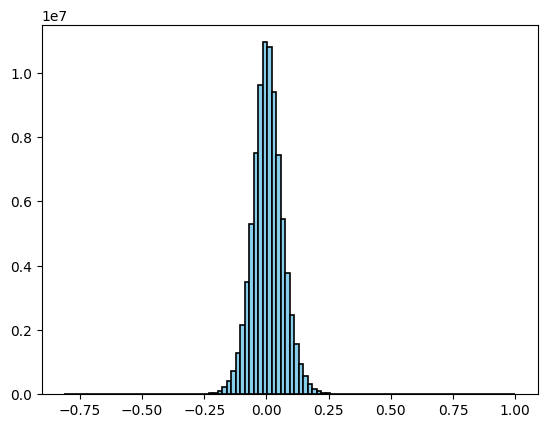

In [10]:
import matplotlib.pyplot as plt

plt.hist(sims, bins=100, color='skyblue', edgecolor='black', linewidth=1.2)
plt.show()

In [14]:
# 32, 64
dot_products = np.dot(decoders['64'].T, decoders['64']) # (32_f, 64_f)
# Change everything over 0.998 to 0.0
# dot_products[dot_products > 0.998] = 0.0
# Take maximum over the  64_f dimension
max_cosine_sims = np.max(dot_products, axis=1) # (32_f,)

In [12]:
max_cosine_sims.shape

(9216,)

In [15]:
# Plotly histogram
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=max_cosine_sims, nbinsx=50)])
fig.show()

In [184]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import json

def calculate_histogram(x, start=0, end=1, bin_size=0.05):
    bins = np.arange(start, end + bin_size, bin_size)
    counts, _ = np.histogram(x, bins=bins)
    # Normalise to be between 0 and 1
    counts = counts / sum(counts)
    return bins[:-1], counts


def plot_multiple_cosine_sims(decoders, save_path=None):
    fig = go.Figure()

    # Color-blind friendly palette
    colors = ['#4e79a7', '#f28e2b', '#59a14f']
    
    pairs = [('32', '64'), ('16', '32'), ('16', '64')]
    
    for i, (model1, model2) in enumerate(pairs):
        cosine_sims = np.dot(decoders[model1].T, decoders[model2])
        max_cosine_sims = np.max(cosine_sims, axis=1)
        
        name = f'SAE{model1}-SAE{model2}'
        
        # Calculate histogram
        bins, density = calculate_histogram(max_cosine_sims)
        
        # Add histogram trace
        fig.add_trace(go.Bar(
            x=bins,
            y=density,
            name=name,
            marker_color=colors[i],
            opacity=1.0,
        ))

        # Print statistics
        mean = np.mean(max_cosine_sims)
        median = np.median(max_cosine_sims)
        print(f"{name} statistics:")
        print(f"  Mean max cosine similarity: {mean:.4f}")
        print(f"  Median max cosine similarity: {median:.4f}")
        print()

        # Add median marker
        fig.add_trace(go.Scatter(
            x=[median],
            y=[0],
            mode='markers',
            marker=dict(symbol='diamond', size=24, color=colors[i], line=dict(width=2, color='white')),
            showlegend=False
        ))

    # Update layout
    fig.update_layout(
        xaxis_title={
            'text': 'Max Cosine Similarity',
            'font': dict(size=30, family='Palatino')
        },
        yaxis_title={
            'text': 'Density',
            'font': dict(size=30, family='Palatino')
        },
        font=dict(family='Palatino'),
        legend=dict(
            title=dict(text='Model Pair', font=dict(size=24)),
            font=dict(size=20)
        ),
        bargap=0.0,
        bargroupgap=0.2,
        plot_bgcolor='white',
        width=1000,
        height=600
    )

    # Update axes
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24),
        range=[0, 1]  # Set x-axis range
    )
    fig.update_yaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        tickfont=dict(size=24)
    )

    if save_path:
        fig.write_image(save_path, scale=2)
        print(f"Figure saved to {save_path}")
    else:
        fig.show()

# Generate the plot
#plot_multiple_cosine_sims(correlation_dict)
# Uncomment the following line to save the plot
plot_multiple_cosine_sims(decoders, '../results/multiple_cosine_sim_histograms.pdf')

SAE32-SAE64 statistics:
  Mean max cosine similarity: 0.6167
  Median max cosine similarity: 0.5891

SAE16-SAE32 statistics:
  Mean max cosine similarity: 0.7942
  Median max cosine similarity: 0.8788

SAE16-SAE64 statistics:
  Mean max cosine similarity: 0.7280
  Median max cosine similarity: 0.7947

Figure saved to ../results/multiple_cosine_sim_histograms.pdf
